In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_bg = pd.read_parquet(r'../datasets/processed/bd/5_business_google.parquet.gz')
df_by = pd.read_parquet(r'../datasets/processed/bd/6_business_yelp.parquet.gz')
df_ug = pd.read_parquet(r'../datasets/processed/bd/4_user_google.parquet.gz')
df_uy = pd.read_parquet(r'../datasets/processed/bd/3_user_yelp.parquet.gz')
df_rg = pd.read_parquet(r'../datasets/processed/bd/9_reviews_google.parquet.gz')
df_ry = pd.read_parquet(r'../datasets/processed/bd/10_reviews_yelp.parquet.gz')

### KPI 1: Mejorar un 10% la accesibilidad de los restaurantes en Florida 

Criterio: Según el ratio de la relación de cantidad de restaurantes sobre cantidad de habitantes por estado, Florida es del menor ratio.

count business_id / habitantes 

In [4]:
# Diccionario con la población de California, Florida, Illinois y New Jersey desde 2015 hasta 2023
population_data = {
    'California': {
        2015: 39144818,
        2016: 39250017,
        2017: 39399349,
        2018: 39538223,
        2019: 39613506,
        2020: 39538223,
        2021: 39296476,
        2022: 39056079,
        2023: 38982847
    },
    'Florida': {
        2015: 20271272,
        2016: 20656589,
        2017: 20984400,
        2018: 21299325,
        2019: 21477737,
        2020: 21538187,
        2021: 21733312,
        2022: 22244823,
        2023: 22733312
    },
    'Illinois': {
        2015: 12859995,
        2016: 12802503,
        2017: 12778828,
        2018: 12741080,
        2019: 12671821,
        2020: 12812508,
        2021: 12671869,
        2022: 12518144,
        2023: 12470000
    },
    'New Jersey': {
        2015: 8958013,
        2016: 9005644,
        2017: 9032872,
        2018: 8908520,
        2019: 8882190,
        2020: 9288994,
        2021: 9261692,
        2022: 9288994,
        2023: 9290000
    }
}

# https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population

In [5]:
# Calcular el número de negocios únicos por habitante por año
businesses_per_capita = {}
for state, population in population_data.items():
    # Filtrar los datos del DataFrame por estado
    df_filtered = df_bg[df_bg['state_id'] == state]
    # Calcular el número de negocios únicos
    unique_businesses = df_filtered['gmap_id'].nunique()
    # Calcular el número de negocios únicos cada 10000 habitantes en 2023
    businesses_per_capita[state] = unique_businesses / population[2023] * 10000

# Mostrar el diccionario resultante
businesses_per_capita

{'California': 6.668830524358572,
 'Florida': 5.845166775523074,
 'Illinois': 6.493985565356856,
 'New Jersey': 8.097954790096878}

/tmp/ipykernel_21637/3793399319.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Negocios por 10,000 habitantes', y='Estado', data=df_businesses_per_capita, palette='viridis')


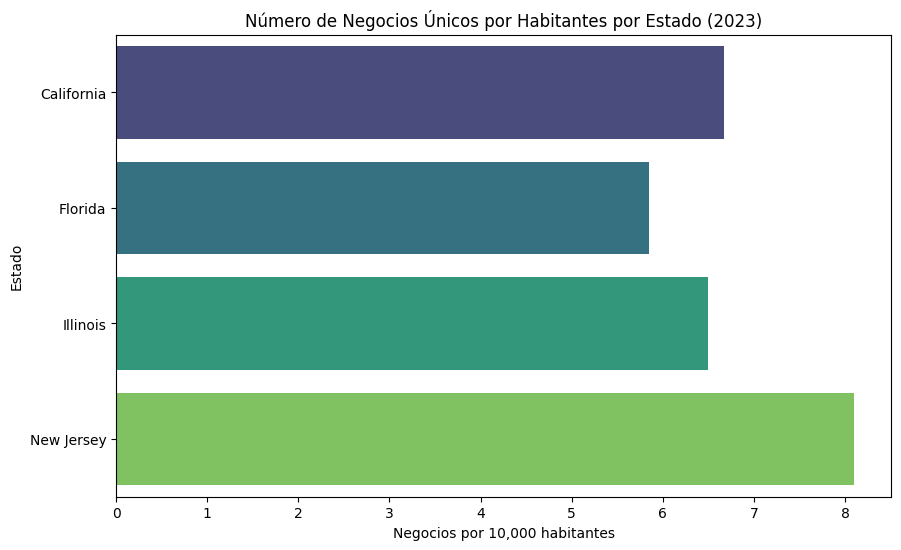

In [6]:
# Convertir el diccionario a un DataFrame para Seaborn
df_businesses_per_capita = pd.DataFrame(list(businesses_per_capita.items()), columns=['Estado', 'Negocios por 10,000 habitantes'])

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Negocios por 10,000 habitantes', y='Estado', data=df_businesses_per_capita, palette='viridis')

# Título y etiquetas
plt.title('Número de Negocios Únicos por Habitantes por Estado (2023)')
plt.xlabel('Negocios por 10,000 habitantes')
plt.ylabel('Estado')
plt.show()

### KPI 2: Aumento 5% rating promedio por grupo de categorías
    correlación entre group y stars a través del tiempo
    business_yelp.json.gz           

output: diccionario metrica por estado por año
kpi: aumento anual metrica

In [7]:

# Merge
merged_df = df_ry.merge(df_by, on='business_id', how='inner')

# contamos categorias
category_counts = merged_df['categories'].apply(pd.Series).stack().value_counts()

# nos quedamos con las 20 más comunes
top_20_categories = category_counts.nlargest(20)
#1.20s

In [8]:
top_20_categories

Restaurants                  909967
Food                         282203
Nightlife                    255083
Bars                         249181
American (Traditional)       196404
American (New)               179059
Breakfast & Brunch           160981
Seafood                      134740
Sandwiches                   124902
Pizza                         99686
Mexican                       92452
Italian                       91129
Burgers                       90181
Salad                         76876
Event Planning & Services     67729
Coffee & Tea                  60914
Cocktail Bars                 58433
Cafes                         57375
Steakhouses                   53579
Desserts                      51767
Name: count, dtype: int64

In [9]:
merged_df.head(1)

,review_id,user_id,business_id,stars_x,sentiment,date,name,latitude,longitude,stars_y,categories,state
0,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,2,2016-07-25 07:31:06,Hibachi Steak House & Sushi Bar,34.416984,-119.695556,3.51,"[Steakhouses, Sushi Bars, Restaurants, Japanese]",California


In [10]:
# dataframe para las top 20
df_categories = top_20_categories.reset_index()
df_categories.columns = ['categories', 'appears']

# Definir grupos de categorías
groups = {
    'fast_food': ['Pizza', 'Burgers', 'Sandwiches'],
    'breakfast': ['Breakfast & Brunch', 'Coffee & Tea', 'Cafes', 'Desserts'],
    'country': ['American (Traditional)', 'American (New)', 'Mexican', 'Italian'],
    'night_events': ['Nightlife', 'Bars', 'Cocktail Bars', 'Event Planning & Services'],
    'generalist': ['Restaurants', 'Food', 'Seafood', 'Salad', 'Steakhouses']
}

# Crear una nueva columna 'group' en el DataFrame
df_categories['group'] = df_categories['categories'].apply(lambda x: next((group for group, categories in groups.items() if x in categories), None))

# Filter the DataFrame to only include necessary categories
group_categories = ['fast_food', 'breakfast', 'country', 'night_events', 'generalist']
df_categories = df_categories[df_categories['group'].isin(group_categories)]

In [11]:
df_categories

,categories,appears,group
0,Restaurants,909967,generalist
1,Food,282203,generalist
2,Nightlife,255083,night_events
3,Bars,249181,night_events
4,American (Traditional),196404,country
5,American (New),179059,country
6,Breakfast & Brunch,160981,breakfast
7,Seafood,134740,generalist
8,Sandwiches,124902,fast_food
9,Pizza,99686,fast_food


In [12]:
def get_categories(df):
    
    """Esta funcion a partir de un dataframe de restaurantes retorna otro con las categorias y los business_id conectados. 

    Returns:
       pd.DataFrame: DataFrame de restaurantes.
    """
    
    #Convierto las categorias de cada fila que estan en listas, a una tabla de id_,categoria.
    categories_data = []
    for index, row in df.iterrows():
        local_id = row['business_id']
        categories = row['categories']
        stars = row['stars']
        for category in categories:
            categories_data.append({'business_id': local_id, 'categories': category, 'stars': stars})

    # Crear un nuevo DataFrame para la tabla de categorías
    categorias_new_data = pd.DataFrame(categories_data)
    # Normalizo a minusculas las categorias
    return categorias_new_data

In [13]:
by_categories= get_categories(df_by[['business_id','stars','categories']])
by_categories.head()

,business_id,categories,stars
0,eEOYSgkmpB90uNA7lDOMRA,Vietnamese,4.09
1,eEOYSgkmpB90uNA7lDOMRA,Food,4.09
2,eEOYSgkmpB90uNA7lDOMRA,Restaurants,4.09
3,eEOYSgkmpB90uNA7lDOMRA,Food Trucks,4.09
4,0bPLkL0QhhPO5kt1_EXmNQ,Food,4.45


In [14]:
# Análisis de correlación entre 'stars' y 'group'
correlation_matrix = by_categories[['stars', 'group']].corr()

#correlation_matrix
group_stars = pd.merge(pd.merge(by_categories,df_filtered,on='categories',how='inner'),df_by[['business_id','stars','state']],on='business_id').groupby(['group','state'])['stars'].mean().reset_index()
group_stars.head()

KeyError: "['group'] not in index"

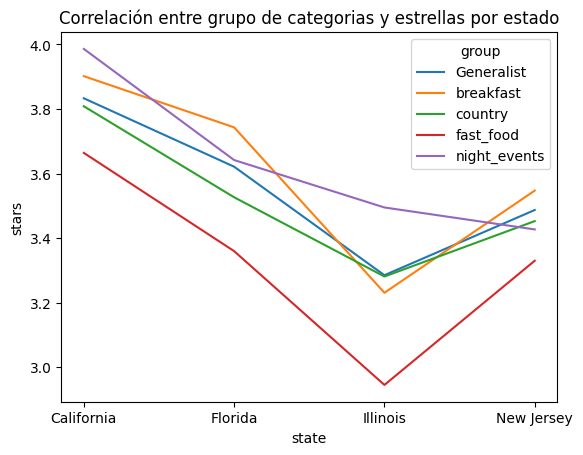

In [ ]:
sns.lineplot(data=group_stars,hue='group',y='stars',x='state')
plt.title('Correlación entre grupo de categorias y estrellas por estado')
plt.show()

In [ ]:

# Filter rows where 'group' is 'Generalist'
generalist_rows = df_by[df_by['group'].apply(lambda x: 'Generalist' in x if x is not None else False)]

# Flatten the lists of categories and get unique categories
generalist_categories = pd.unique([category for sublist in generalist_rows['categories'] for category in sublist])
generalist_categories

/tmp/ipykernel_7556/3737035431.py:9: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  generalist_categories = pd.unique([category for sublist in generalist_rows['categories'] for category in sublist])


array(['Vietnamese', 'Food', 'Restaurants', 'Food Trucks', 'French',
       'Moroccan', 'Seafood', 'Mediterranean', 'Barbeque', 'Hawaiian',
       'Street Vendors', 'Sushi Bars', 'Japanese', 'Ethnic Food',
       'Specialty Food', 'Thai', 'Puerto Rican', 'Caribbean',
       'Latin American', 'Festivals', 'Arts & Entertainment',
       'Local Flavor', 'Food Stands', 'Kebab', 'Middle Eastern',
       'Lebanese', 'Greek', 'Asian Fusion', 'Chinese', 'Poke',
       'Acai Bowls', 'Pretzels', 'Bakeries', 'Delis', 'Peruvian', 'Vegan',
       'Wraps', 'Salad', 'Steakhouses', 'Gluten-Free', 'Fast Food',
       'Chicken Shop', 'Chicken Wings', 'Teppanyaki', 'Szechuan',
       'Noodles', 'Diners', 'Falafel', 'Halal', 'Grocery',
       'Do-It-Yourself Food', 'Seafood Markets', 'Turkish', 'German',
       'Korean', 'Hot Pot', 'Indian', 'Pakistani', 'Vegetarian',
       'Custom Cakes', 'Meat Shops', 'Buffets', 'International Grocery',
       'Arabic', 'Bagels', 'Hot Dogs', 'Active Life', 'Golf',
    

# KPI 3: Mejorar la tasa de diferencia entre reviews y respuestas 
"Aumentar la calidad de la comunicación a través de un mejor ratio respuestas por comentarios y  disminuir el tiempo promedio de respuestas"

kpi = (ratio respuestas/review * rango tiempo) + sentiment_resp promedio

Métricas: respuesta/review, tiempo promedio y sentiment_resp promedio           
    se puede hacer con: business_id, resp time != 0 o != NaT, resp_sentiment !=0, date con formato H M S            
    reviews_google.parquet.gz         

In [ ]:
# Convertir 'date' y 'resp_date' al formato datetime
df_rg['date'] = pd.to_datetime(df_rg['date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df_rg['resp_date'] = pd.to_datetime(df_rg['resp_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Fusionar los dataframes en 'gmap_id'
merged_df = pd.merge(df_rg, df_bg, on='gmap_id', how='inner')

# Filtrar las filas donde 'resp_time' no es NaT
filtered_df = merged_df[~pd.isna(merged_df['resp_date'])]

# Calcular la ratio de respuesta/review
ratio_resp_review = filtered_df.groupby('name').size()

# Calcular la diferencia de tiempo en horas
filtered_df['tiempo_diff'] = (filtered_df['resp_date'] - filtered_df['date']).dt.total_seconds() / 3600

# Calcular el sentiment_resp promedio
sentiment_resp_promedio = filtered_df.groupby('name')['resp_sentiment'].mean()

# Mostrar los resultados en un nuevo DataFrame
result_df = pd.DataFrame({
    'ratio_resp': ratio_resp_review.values / filtered_df.groupby('name').size().values,
    'tiempo_resp': filtered_df.groupby('name')['tiempo_diff'].mean(),
    'sentiment_resp': sentiment_resp_promedio.values
})
result_df

/tmp/ipykernel_65112/434147560.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tiempo_diff'] = (filtered_df['resp_date'] - filtered_df['date']).dt.total_seconds() / 3600


,ratio_resp,tiempo_resp,sentiment_resp
name,,,
"""SAVE ME SOME""",1.0,659.478385,0.036506
$,1.0,5.233475,0.260000
&pizza - Union,1.0,145.870820,0.322729
1-800-Lucky,1.0,485.512549,0.262305
1000 Degrees Pizza Salad Wings,1.0,60.364812,0.356418
...,...,...,...
zpizza,1.0,9851.357478,0.483540
“Tacos El Patrón” Mexican Food Truck,1.0,343.280732,0.387500
关东大院,1.0,112.172740,0.312500


In [ ]:
import pandas as pd

# Convertir 'date' y 'resp_date' al formato datetime
df_rg['date'] = pd.to_datetime(df_rg['date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df_rg['resp_date'] = pd.to_datetime(df_rg['resp_date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Fusionar los dataframes en 'gmap_id'
merged_df = pd.merge(df_rg, df_bg, on='gmap_id', how='inner')

# Filtrar las filas donde 'resp_time' no es NaT
filtered_df = merged_df[~pd.isna(merged_df['resp_date'])]


# Calcular 'tiempo_diff' en una nueva variable
tiempo_diff = (filtered_df['resp_date'] - filtered_df['date']).dt.total_seconds() / 3600

# Asignar la nueva variable a 'filtered_df'
filtered_df['tiempo_diff'] = tiempo_diff

# Calcular la ratio de respuesta/review
ratio_resp_review = filtered_df.groupby('name').size()

# Calcular el sentiment_resp promedio
sentiment_resp_promedio = filtered_df.groupby('name')['resp_sentiment'].mean()

# Mostrar los resultados en un nuevo DataFrame con 'name' como índice
result_df = pd.DataFrame({
    'ratio_resp': ratio_resp_review.values / filtered_df.groupby('name').size().values,
    'tiempo_resp': filtered_df.groupby('name')['tiempo_diff'].mean(),
    'sentiment_resp': sentiment_resp_promedio.values
}, index=ratio_resp_review.index)

# Mostrar el DataFrame resultante
result_df

/tmp/ipykernel_100869/489617714.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tiempo_diff'] = tiempo_diff


,ratio_resp,tiempo_resp,sentiment_resp
name,,,
"""SAVE ME SOME""",1.0,659.478385,0.036506
$,1.0,5.233475,0.260000
&pizza - Union,1.0,145.870820,0.322729
1-800-Lucky,1.0,485.512549,0.262305
1000 Degrees Pizza Salad Wings,1.0,60.364812,0.356418
...,...,...,...
zpizza,1.0,9851.357478,0.483540
“Tacos El Patrón” Mexican Food Truck,1.0,343.280732,0.387500
关东大院,1.0,112.172740,0.312500


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Crear un gráfico de barras múltiples para cada métrica
plt.figure(figsize=(12, 8))
sns.barplot(x=result_df.index, y='ratio_resp', data=result_df, color='blue', label='Ratio Respuesta/Review')
sns.barplot(x=result_df.index, y='tiempo_resp', data=result_df, color='orange', label='Tiempo Respuesta (horas)')
sns.barplot(x=result_df.index, y='sentiment_resp', data=result_df, color='green', label='Sentimiento Respuesta')

# Añadir título y etiquetas de los ejes
plt.title('Métricas por Negocio')
plt.xlabel('Negocio')
plt.ylabel('Valor')

# Rotar los nombres de los negocios para mejorar la legibilidad
plt.xticks(rotation=90)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


# KPI 4: Aumentar 5% la tasa de retención de cliente            
Métricas: count distinct usuario con reviews > 1
    reviews_google.parquet.gz           
segun distribucion de datos, x > 1 es valido para decir que es cliente habitual          
establecer rangos

In [ ]:
# Convertir 'date' al formato datetime
df_rg['date'] = pd.to_datetime(df_rg['date'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Filtrar usuarios con más de 1 review
usuarios_repetidos = df_rg['user_id'][df_rg.groupby('user_id')['date'].transform('count') > 1].nunique()

# Número total de usuarios distintos
usuarios_totales = df_rg['user_id'].nunique()

# Calcular la tasa de retención actual
tasa_retencion_actual = usuarios_repetidos / usuarios_totales

# Calcular la tasa de retención objetivo (aumento del 5%)
tasa_retencion_objetivo = tasa_retencion_actual * 1.05

# Calcular el número adicional de usuarios repetidos necesarios para alcanzar el objetivo
usuarios_repetidos_necesarios = int(usuarios_totales * tasa_retencion_objetivo) - usuarios_repetidos

# Mostrar los resultados
print(f"Tasa de retención: {tasa_retencion_actual:.2%}")
print(f"Objetivo: {tasa_retencion_objetivo:.2%}")
print(f"Usuarios repetidos necesarios: {usuarios_repetidos_necesarios}")


Tasa de retención: 39.86%
Objetivo: 41.85%
Usuarios repetidos necesarios: 27275


KPIs:

Enfoque técnico: Optimización del alcance y calidad del servicio      

KPI 1: Mejorar un 10% la accesibilidad de los restaurantes en Florida      
Métricas: Cantidad de restaurantes por estado cada 1000 habitantes        
    business_google.json.gz         

KPI 2: Aumento 5% rating promedio por grupo de categorías 
Métricas: correlación entre group y stars a través del tiempo  
    business_yelp.json.gz  


Enfoque orgánico: Networking            

KPI 3: Mejorar respuestas 
"Aumentar la calidad de la comunicación a través de un mejor ratio respuestas por comentarios y  disminuir el tiempo promedio de respuestas"

kpi = (ratio respuestas/review * rango tiempo) + sentiment_resp promedio

Métricas: respuesta/review, tiempo promedio y sentiment_resp promedio       
    reviews_google.parquet.gz           

KPI 4: Aumentar 5% la tasa de retención de cliente            
Métricas: count distinct usuario con reviews > 1
    reviews_google.parquet.gz           
segun distribucion de datos, x > 1 es valido para decir que es cliente habitual?           
establecer rangos

KPI 5: Aumentar 10% reviews de usuarios poco influyentes y 1% muy influyente            
Métricas: Cantidad de usuarios inluyentes y poco influyentes         
    users_yelp.parquet.gz 


    
metricas        
ratio useful/review-count       
distribucion de reviews por mes

Sistema de recomendación para empresas: Análisis de ubicación       
    Por cantidad competencia en la zona     
    Por calidad competencia en la zona      
    Por horario por atributo            
Sistema de recomendación para empresas: Publicidad      
    Promoción por gustos del usuario        
    Por gustos de usuarios similares        
    Por gustos de amigos del usuario        


### KPI 5: Aumentar 10% reviews de usuarios poco influyentes y 1% muy influyente            
Métricas: Cantidad de usuarios por rango influencia         
    users_yelp.parquet.gz 


In [ ]:
# Definir rangos de influencia
def rango_influyente(cant_fans):
    if cant_fans < 10:
        return 0  # Bajo influencia
    elif cant_fans < 100:
        return 1  # Moderada influencia
    else:
        return 2  # Alta influencia

# Aplicar la función de influencia para crear la columna 'influence'
df_uy['influence'] = df_uy['review_count'].apply(rango_influyente)

# Calcular la cantidad de usuarios en cada rango de influencia
usuarios_por_influencia = df_uy.groupby('influence').size().to_dict()

# Calcular los objetivos de aumento
objetivo_aumento_bajo = int(usuarios_por_influencia.get(0, 0) * 0.10)
objetivo_aumento_medio = int(usuarios_por_influencia.get(1, 0) * 0.01)

# Mostrar los resultados en un diccionario
kpi5_metrics = {
    'Usuarios por influencia': usuarios_por_influencia,
    'Objetivo usuarios influyentes': objetivo_aumento_bajo,
    'Objetivo usuarios muy influyentes': objetivo_aumento_medio
}
kpi5_metrics


{'Usuarios por influencia': {0: 340388, 1: 12586, 2: 271},
 'Objetivo usuarios influyentes': 34038,
 'Objetivo usuarios muy influyentes': 125}

/tmp/ipykernel_65112/1390716702.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(df_uy['influence'].value_counts(), palette='deep')


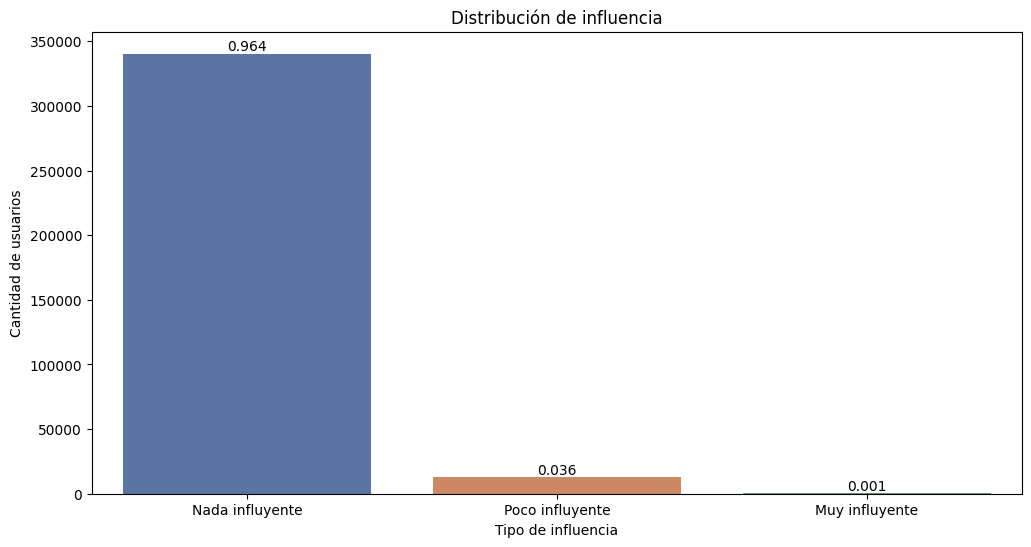

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una figura con un tamaño específico
plt.figure(figsize=(12, 6))

# Crear un gráfico de barras utilizando Seaborn
ax = sns.barplot(df_uy['influence'].value_counts(), palette='deep')

# Añadir título al gráfico
plt.title('Distribución de influencia')

# Etiquetas de los ejes
plt.xlabel('Tipo de influencia')
plt.ylabel('Cantidad de usuarios')

# Añadir etiquetas con porcentaje en la parte superior de las barras
for i, valor in enumerate(df_uy['influence'].value_counts()):
    porcentaje = round(valor / (len(df_uy)), 3)
    ax.annotate(f"{porcentaje}", (i, valor), ha='center', va='bottom')

# Añadir etiquetas personalizadas en el eje x
plt.xticks([0, 1, 2], ['Nada influyente', 'Poco influyente', 'Muy influyente'])

# Mostrar el gráfico
plt.show()
